# Indeed.com:  Salary Prediction

In this notebook, we'll scrape the [top 25 most-populous](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) -- plus [several other tech-heavy](http://www.informationweek.com/big-data/big-data-analytics/10-best-us-cities-for-tech-jobs-in-2016/d/d-id/1325592) -- cities on Indeed.com for salary listings using the search term "Data Scientist".  Then, we'll construct a logistic regression model to predict whether a given listing will have a salary above or below the median of collected salaries.

First, we import and set up our environment:

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
import requests
from bs4 import BeautifulSoup
import re

from scipy.stats import gaussian_kde
from nltk.stem.porter import *

from matplotlib import pyplot as plt
from matplotlib import cm as cm2
from matplotlib import patheffects as path_effects

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, \
                                    roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, \
                                    GridSearchCV
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.svm import SVR

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Here are some functions we will use to process the scrapes:

In [2]:
def get_jobtitle(result):
    '''This function constructs a list containing each job title.'''
    jobtitle_list = []
    try:
        for i in result.findAll('a', class_ = 'jobtitle turnstileLink'): 
            jobtitle_list.append(str(i.text.encode('utf8')))
    except:
        jobtitle_list.append(None)
    return jobtitle_list

def get_location(result):
    '''This function constructs a list containing each job location.'''
    location_list = []
    try:
        for i in result.findAll('span', class_ = 'location'):
            location_list.append(str(i.text.encode('utf8')))
    except:
        location_list.append(None)
    return location_list

def get_company(result):   
    '''This function constructs a list containing each job company.'''
    company_list = []
    try:
        for i in result.findAll('span', class_ = 'company'):
            company = str(i.text.encode('utf8'))
            company = company.replace('\n', '')
            company = company.replace('    ', '')
            company_list.append(company)
    except:
        company_list.append(None)
    return company_list
    
def get_salary(result):
    '''This function constructs a list containing each job salary.'''
    salary_list = []
    try:
        for i in result.findAll('td', class_ = 'snip'):
            try:
                salary_list.append(i.find('nobr').text)
            except:
                salary_list.append(None)
    except:
        salary_list.append(None)
    return salary_list

def putitalltogether(result):
    '''This function creates a dataframe whose columns are the lists produced \
    by the functions it contains.'''
    jobs = get_jobtitle(result)
    locations = get_location(result)
    companies = get_company(result)
    salaries = get_salary(result)
    df = pd.DataFrame(zip(jobs, locations, companies, salaries),\
                        columns = ['title', 'location', 'company', 'salary']) 
    return df

In [3]:
url_template = ['http://www.indeed.com/jobs?q=data+scientist&l=', '&start=']

max_results_per_city = 1000

## Create empty dataframe with the columns we want; \
## concatenate to it the new one generated for each city

df = pd.DataFrame(columns=['title', 'location', 'company', 'salary', 'city', 'state'])

count = 0

starter = datetime.datetime.now()
print starter

cities = ['New+York,+NY', 'Los+Angeles,+CA', 'Chicago,+IL', 'Houston,+TX', 'Philadelphia,+PA', \
          'Phoenix,+AZ', 'San+Antonio,+TX', 'San+Diego,+CA', 'Dallas,+TX', 'San+Jose,+CA', \
          'Austin,+TX', 'Jacksonville,+FL', 'San+Francisco,+CA', 'Indianapolis,+IN', \
          'Columbus,+OH', 'Fort+Worth,+TX', 'Charlotte,+NC', 'Seattle,+WA', 'Denver,+CO', \
          'El+Paso,+TX', 'Detroit,+MI', 'Washington,+DC', 'Boston,+MA', 'Memphis,+TN', \
          'Nashville,+TN', 'Salt+Lake+City,+UT', 'Raleigh-Durham,+NC', \
            'Minneapolis-St+Paul,+MN', 'St+Louis,+MO', 'Cleveland,+OH', 'Palo+Alto,+CA', \
            'Mountain+View,+CA']

for city in cities:
    print city.split(',')[0].replace('+', ' '),
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        URL = url_template[0] + city + url_template[1] + str(start)
        indeed = requests.get(URL)
        soup = BeautifulSoup(indeed.content, "lxml")
        # Append to the full set of results and 
        big = putitalltogether(soup)
        nice_city = city.split(',')
        state = nice_city[1]
        state = state.replace('+', '')
        nice_city = nice_city[0]
        nice_city = nice_city.replace('+', ' ')
        big['city'] = nice_city
        big['state'] = state
        df = pd.concat([big, df], axis = 0) 
        if count%50 == 0:
            print '.',
        count += 1
        
finish = datetime.datetime.now()
print finish - starter
        
df.to_csv('assets/indeed_rough.csv', index = False)

2017-03-06 00:35:49.089279
New York . . Los Angeles . . Chicago . . Houston . . Philadelphia . . Phoenix . . San Antonio . . San Diego . . Dallas . . San Jose . . Austin . . Jacksonville . . San Francisco . . Indianapolis . . Columbus . . Fort Worth . . Charlotte . . Seattle . . Denver . . El Paso . . Detroit . . Washington . . Boston . . Memphis . . Nashville . . Salt Lake City . . Raleigh-Durham . . Minneapolis-St Paul . . St Louis . . Cleveland . . Palo Alto . . Mountain View . . 0:21:35.261136


The following cell loads the data frame constructed during the scrape:

In [130]:
df = pd.read_csv('assets/indeed_rough.csv')
orig = len(df)
df.head()

,title,location,company,salary,city,state
0,Data Scientist,"Mountain View, CA 94039",Intuit,NaN,Mountain View,CA
1,Machine Learning Scientist,"Sunnyvale, CA",Amazon Corporate LLC,NaN,Mountain View,CA
2,Quantitative Data Scientist,"Palo Alto, CA 94306 (Barron Park area)",Groupon,NaN,Mountain View,CA
3,Data Scientist / Engineer / Statistician,"Mountain View, CA",Google,NaN,Mountain View,CA
4,Machine Learning Engineer/ Data Scientist,"Menlo Park, CA",Enfec,NaN,Mountain View,CA


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19895 entries, 0 to 19894
Data columns (total 6 columns):
title       19895 non-null object
location    19895 non-null object
company     19895 non-null object
salary      575 non-null object
city        19895 non-null object
state       19895 non-null object
dtypes: object(6)
memory usage: 932.6+ KB


Whoa, looks like we only have 556 non-null salary entries.  Let's get rid of all observations containing empty salary cells:

In [132]:
df = df.dropna()
df = df.drop_duplicates()
df.reset_index(drop = True, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 6 columns):
title       151 non-null object
location    151 non-null object
company     151 non-null object
salary      151 non-null object
city        151 non-null object
state       151 non-null object
dtypes: object(6)
memory usage: 7.1+ KB


In [133]:
len(df)/float(orig)

0.007589846695149535

So we're already down to about 0.76% of the original scrape without any advanced cleaning!

#### Filter out the salaries that are not yearly:

In [134]:
df = df[df['salary'].str.contains('month') == False]
df = df[df['salary'].str.contains('week') == False]
df = df[df['salary'].str.contains('hour') == False]
df = df[df['salary'].str.contains('day') == False]

In [135]:
print 'Of %s' %len(df[df['salary'] != 'NaN']) +' salaries remaining, %s' \
%len(df[df['salary'].str.contains('year')]) +' are explicitly labeled as \'yearly.\''

Of 94 salaries remaining, 94 are explicitly labeled as 'yearly.'


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [136]:
df['salary'] = [x.replace('$', '') for x in df['salary']]
df['salary'] = [x.replace(',', '') for x in df['salary']]
df['salary'] = [x.replace(' a year', '') for x in df['salary']]
df['salary'] = [x.split(' - ') for x in df['salary']]
df['salary'] = [float(x[0]) if len(x) == 1 else (float(x[0]) + float(x[1]))/2.0 for x in df['salary']]
df['salary'][0:5]

1    210000.0
3    170000.0
4    175000.0
5    160000.0
6    175000.0
Name: salary, dtype: float64

Let's see what a histogram of the salary column looks like:

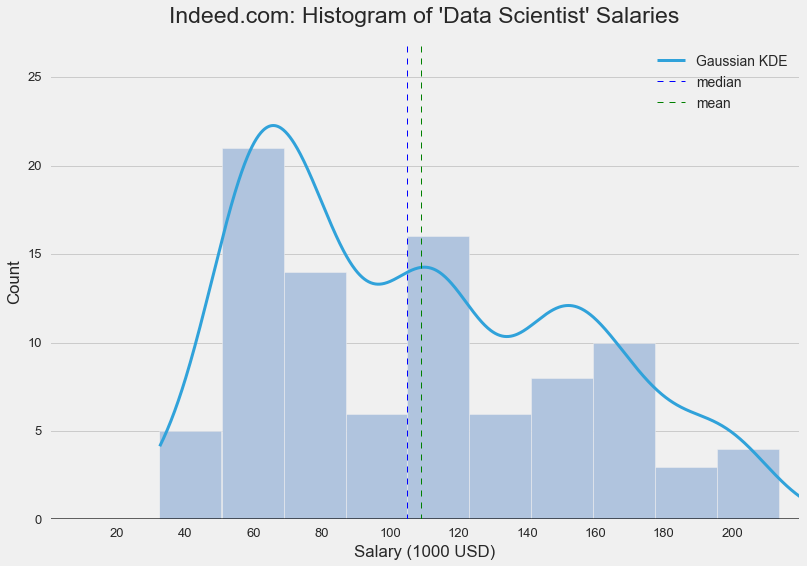

In [137]:
plt.figure(figsize = (12,8))
plt.style.use('fivethirtyeight')

df['salary'].hist(bins = 12, color = 'lightsteelblue')

density = gaussian_kde(df['salary'])
xs = np.linspace(df['salary'].min(), df['salary'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs)*10000000/4.5, linewidth = 3.0, label = 'Gaussian KDE')

plt.title('Indeed.com: Histogram of \'Data Scientist\' Salaries', fontsize = 23, y = 1.03)
plt.ylim([0, 27])
plt.yticks(range(0, 30, 5), fontsize = 13)
plt.ylabel('Count')
plt.xlim([0, 200000])
plt.xticks(range(20000, 240000, 20000), range(20, 220, 20), fontsize = 13)
plt.xlabel('Salary (1000 USD)')

plt.axhline(0, color = 'black', alpha = 0.6)
plt.axvline(df['salary'].median(), color='b', linestyle='dashed', linewidth=1.0, \
            label = 'median')
plt.axvline(df['salary'].mean(), color='g', linestyle='dashed', linewidth=1.0, \
            label = 'mean')

plt.grid(which='major', axis = 'x')
plt.legend(loc = 'best', fontsize = 14)
plt.show()

Hmmm, maybe those are local maxima at Bachelor's, Master's, and Doctoral degrees?  Let's examine companies:

In [138]:
df['company'].value_counts()

The University of Arizona                                7
Jobspring Partners                                       6
Red Oak Strategic                                        5
University Of Utah                                       5
W3Global                                                 4
Cottonwood Financial                                     4
LT                                                       4
Workbridge Associates                                    4
Harnham                                                  3
Washington University in St. Louis                       3
Syntelli Solutions, Inc                                  3
Lighthouse Recruiting                                    2
University of Utah                                       2
TW STAFFING SOLUTIONS,INC                                2
MD Anderson Cancer Center                                1
Phoenix 2.0                                              1
Salt Lake County                                        

We'll leave that alone for now since there are so many distinct listings.  Now, let's see a bar chart of all the states included in the scrape:

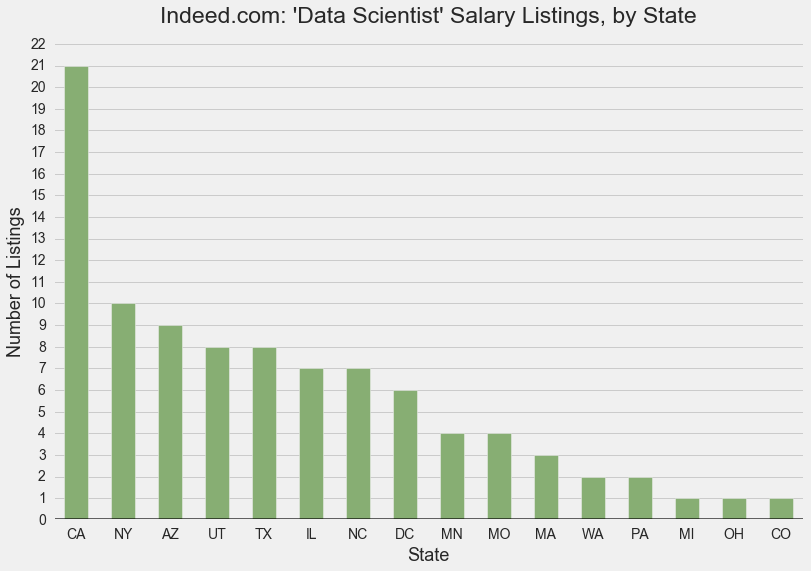

In [139]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df['state'].value_counts().plot.bar(color = 'sage')

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: \'Data Scientist\' Salary Listings, by State', fontsize = 23, y = 1.03)

# y label
plt.ylabel('Number of Listings', fontsize = 18)
plt.yticks(range(0, 23, 1), fontsize = 14)
plt.ylim([0, 22.1])

# x label
plt.xlabel('State', fontsize = 18)
plt.xticks(rotation = 0, fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

And a bar chart of all the cities included in the scrape:

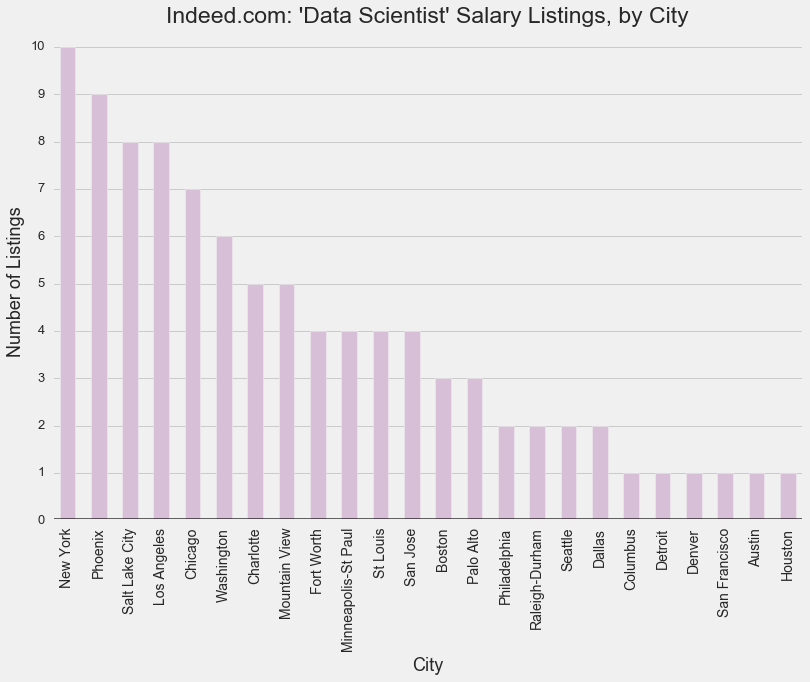

In [140]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df['city'].value_counts().plot.bar(color = 'thistle', alpha = 1.0)

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: \'Data Scientist\' Salary Listings, by City', fontsize = 23, y = 1.03)

# y label
plt.ylabel('Number of Listings', fontsize = 18)
plt.ylim([0, 10.1])
plt.yticks(range(0, 11, 1), fontsize = 13)

# x label
plt.xlabel('City', fontsize = 18)
plt.xticks(fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [141]:
print 'The minimum salary listed is %s' %min(df['salary'])
df[df['salary'] == min(df['salary'])][['title', 'location', 'company', 'salary']]

The minimum salary listed is 32500.0


,title,location,company,salary
48,Data Engineer,"Newton, MA","Asset Recovery Advisors, Inc.",32500.0


In [142]:
print 'The maximum salary listed is %s' %max(df['salary'])
df[df['salary'] == max(df['salary'])][['title', 'location', 'company', 'salary']]

The maximum salary listed is 250000.0


,title,location,company,salary
111,Data Engineer/Scientist,"Philadelphia, PA",Averity,250000.0


#### Compute the median salary and create a new binary target variable with 1 if the salary is above the median, and 0 otherwise:

In [143]:
df['target'] = [1 if x > df['salary'].median() else 0 for x in df['salary']]

In [144]:
df['salary'].median()

105000.0

Let's see it if looks like a 50-50 split of observations:

In [145]:
df['target'].value_counts()

0    50
1    44
Name: target, dtype: int64

Make a list of (non-unique) terms found in 'title' entries; ignore case and symbols:

In [176]:
df['title1'] = df['title'].apply(lambda x: re.sub(r'[^\w]', ' ', x.lower()))
df['title1'] = df['title1'].apply(lambda x: x.lower())
df['title1'] = df['title1'].apply(lambda x: x.replace('ai ', 'artificialintelligence '))
df['title1'] = df['title1'].apply(lambda x: x.replace('artificial intelligence', 'artificialintelligence'))
df['title1'] = df['title1'].apply(lambda x: x.replace('2', 'ii'))
df['title1'] = df['title1'].apply(lambda x: x.replace('machine learning', 'machinelearning'))
df['title1'] = df['title1'].apply(lambda x: x.replace('big data', 'bigdata'))
df['title1'] = df['title1'].apply(lambda x: x.replace('data scientist', 'datascience'))
df['title1'] = df['title1'].apply(lambda x: x.replace('data science', 'datascience'))
df['title1'] = df['title1'].apply(lambda x: x.replace('computer scientist', 'computerscience'))
df['title1'] = df['title1'].apply(lambda x: x.replace('computer science', 'computerscience'))
df['title1'] = df['title1'].apply(lambda x: x.replace(' sr ', ' senior '))
df['title1'] = df['title1'].apply(lambda x: x.replace(' jr ', ' junior '))
df['title1'] = df['title1'].apply(lambda x: x.replace('and', ''))
df['title1'] = df['title1'].apply(lambda x: list(set(x.split())))
df['title2'] = [None]*len(df)

df = df.reset_index(drop = True)

stemmer = PorterStemmer()

for i in range(len(df)):
    df['title2'][i] = [x for x in df['title1'][i] if len(x) > 1]
    df['title2'][i] = [x.strip() for x in df['title2'][i]]
    df['title2'][i] = [stemmer.stem(x) for x in df['title2'][i]]

In [177]:
all_terms = []
for i in df['title2']:
    i = list(set(i))
    all_terms = all_terms + i
unique_terms = list(set(all_terms))
term_counts = []
for i in unique_terms:
    count = all_terms.count(i)
    term_counts.append(count)
count_df = pd.DataFrame([unique_terms, term_counts]).T
count_df.columns = ['term', 'count']
count_df = count_df[count_df['count'] > 1]
count_df = count_df.sort_values(by = 'count', ascending = False)
count_df

,term,count
13,datasci,51
19,engin,15
51,analyst,14
12,scientist,14
44,machinelearn,11
26,research,10
59,quantit,8
0,nlp,7
49,develop,7
67,senior,7


In [178]:
terms = count_df[count_df['count'] > 1]['term']            

In [179]:
def dummies(feature, terms):
    lil_df = pd.DataFrame()
    for term in terms:
        name = '_' + str(term) + '_'
        lil_df[name] = [1 if term in x else 0 for x in feature]
    return lil_df

In [180]:
dummy_df = dummies(df['title2'], terms)

In [181]:
big_df = pd.concat([df.drop(['title1', 'title2'], axis = 1), dummy_df], axis = 1)

In [182]:
df.groupby(['state', 'city'])['title'].count()

state  city               
AZ     Phoenix                 9
CA     Los Angeles             8
       Mountain View           5
       Palo Alto               3
       San Francisco           1
       San Jose                4
CO     Denver                  1
DC     Washington              6
IL     Chicago                 7
MA     Boston                  3
MI     Detroit                 1
MN     Minneapolis-St Paul     4
MO     St Louis                4
NC     Charlotte               5
       Raleigh-Durham          2
NY     New York               10
OH     Columbus                1
PA     Philadelphia            2
TX     Austin                  1
       Dallas                  2
       Fort Worth              4
       Houston                 1
UT     Salt Lake City          8
WA     Seattle                 2
Name: title, dtype: int64

In [183]:
CA = ['Los Angeles', 'Mountain View', 'Palo Alto', 'San Francisco', 'San Jose']
NC = ['Charlotte', 'Raleigh-Durham']
TX = ['Austin', 'Dallas', 'Fort Worth', 'Houston']

big_df['is_CA'] = [1 if x in CA else 0 for x in big_df['city']]
big_df['is_NC'] = [1 if x in NC else 0 for x in big_df['city']]
big_df['is_TX'] = [1 if x in TX else 0 for x in big_df['city']]

In [184]:
big_df = pd.concat([big_df.drop(['city', 'state'], axis = 1), 
                    pd.get_dummies(big_df['city'])], axis = 1)

big_df.drop(['New York'], axis = 1, inplace = True)

In [185]:
big_df.columns

Index([u'title', u'location', u'company', u'salary', u'target', u'_datasci_',
       u'_engin_', u'_analyst_', u'_scientist_', u'_machinelearn_',
       u'_research_', u'_quantit_', u'_nlp_', u'_develop_', u'_senior_',
       u'_data_', u'_artificialintellig_', u'_ii_', u'_model_', u'_market_',
       u'_bigdata_', u'_analyt_', u'_scienc_', u'_laboratori_', u'_associ_',
       u'_artifici_', u'_statistician_', u'_appli_', u'_alexa_', u'_junior_',
       u'_softwar_', u'_bioinformat_', u'_iii_', u'_applic_', u'_formul_',
       u'_risk_', u'_valid_', u'_execut_', u'_sk00113_', u'is_CA', u'is_NC',
       u'is_TX', u'Austin', u'Boston', u'Charlotte', u'Chicago', u'Columbus',
       u'Dallas', u'Denver', u'Detroit', u'Fort Worth', u'Houston',
       u'Los Angeles', u'Minneapolis-St Paul', u'Mountain View', u'Palo Alto',
       u'Philadelphia', u'Phoenix', u'Raleigh-Durham', u'Salt Lake City',
       u'San Francisco', u'San Jose', u'Seattle', u'St Louis', u'Washington'],
      dtype='object

Perform a logistic regression on the salary dummy column using the term dummy columns as model features:

In [186]:
X = big_df.drop(['title', 'location', 'company', 'salary', 'target'], axis = 1)

y = big_df['target']

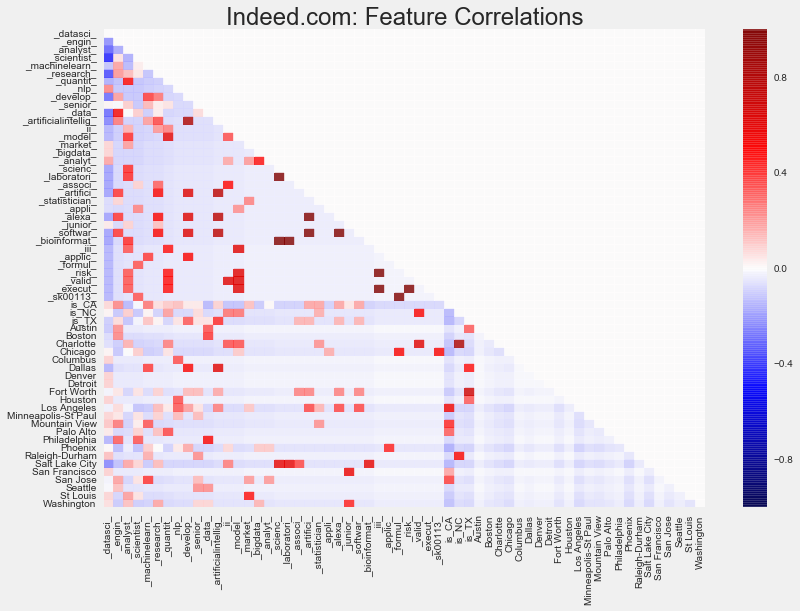

In [187]:
plt.figure(figsize = (12, 8))
plt.style.use('fivethirtyeight')

corr_mat = np.tril(X.corr(), k=-1)
sns.heatmap(corr_mat, cmap = 'seismic', alpha = 0.8)
plt.title('Indeed.com: Feature Correlations', fontsize = 24)
plt.xticks(np.arange(0.5, len(X.columns) + 0.5, 1), X.columns, fontsize = 10, rotation = 90)
plt.yticks(np.arange(0.5, len(X.columns) + 0.5, 1), list(X.columns)[::-1], fontsize = 10, rotation = 0)
plt.show()

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [189]:
parameters = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.01, 0.1, 0.5, 1.0, 5, 10, 100],
}

lr = LogisticRegression(fit_intercept = True, random_state=42, n_jobs = -1)

clf = GridSearchCV(lr, parameters, cv = 5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1.0, 5, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [190]:
clf.best_params_

{'C': 0.5, 'penalty': 'l2'}

In [191]:
lr2 = LogisticRegression(fit_intercept = True, C = clf.best_params_['C'], \
                         penalty = clf.best_params_['penalty'], random_state = 42)

lr2.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [192]:
predictions = lr2.predict(X_test)
cm = confusion_matrix(predictions, y_test)
cm

array([[13,  7],
       [ 1,  8]])

In [193]:
accuracy_score(predictions, y_test)

0.72413793103448276

In [194]:
coefs = pd.DataFrame(index = X.columns)
coefs['coef'] = list(lr2.coef_)[0]
coefs['color'] = ['blue' if x <=0 else 'red' for x in coefs['coef']]
coefs['coef'] = [abs(x) for x in coefs['coef']]
coefs = coefs.sort_values(by = 'coef', ascending = False)

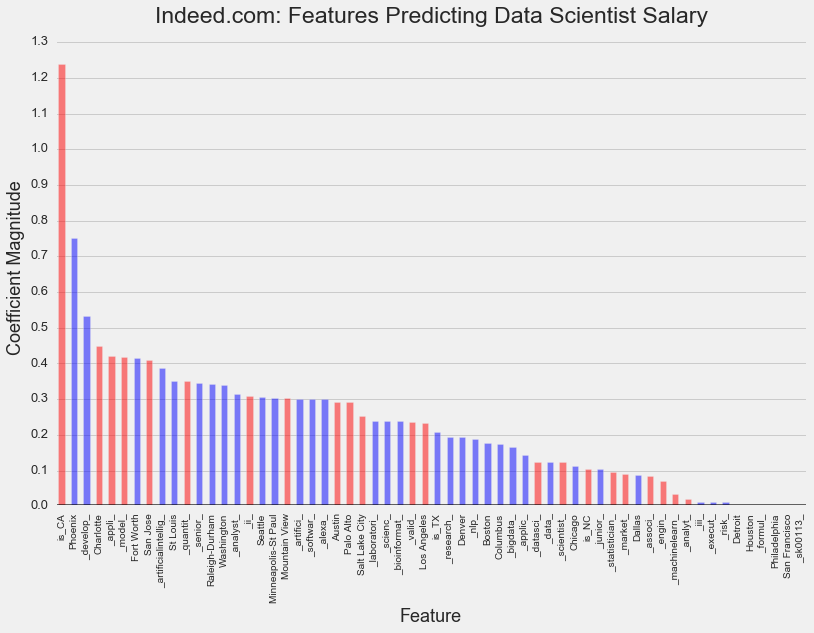

In [195]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

coefs['coef'].plot.bar(color = coefs['color'], alpha = 0.5)

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: Features Predicting Data Scientist Salary', fontsize = 23)

plt.ylabel('Coefficient Magnitude', fontsize = 18)
plt.ylim([0, coefs['coef'].max() + 0.1])
plt.yticks(np.arange(0, coefs['coef'].max() + 0.1, 0.1), fontsize = 13)

plt.xlabel('Feature', fontsize = 18)
plt.xticks(fontsize = 10)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [196]:
accuracies = []
precisions = []
recalls = []

for i in range(1, len(X.columns)):
    pick_em = SelectKBest(f_classif, k=i)
    pick_em.fit(X_train, y_train)
    support = X.columns[pick_em.get_support()]
    lr2.fit(X_train[support], y_train)
    y_pred = lr2.predict(X_test[support])
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    
results = pd.DataFrame(index = range(len(X.columns) - 1))
results['accuracy'] = accuracies
results['precision'] = precisions
results['recall'] = recalls

In [197]:
results.head()

,accuracy,precision,recall
0,0.655172,1.0,0.333333
1,0.655172,1.0,0.333333
2,0.655172,1.0,0.333333
3,0.655172,1.0,0.333333
4,0.655172,1.0,0.333333


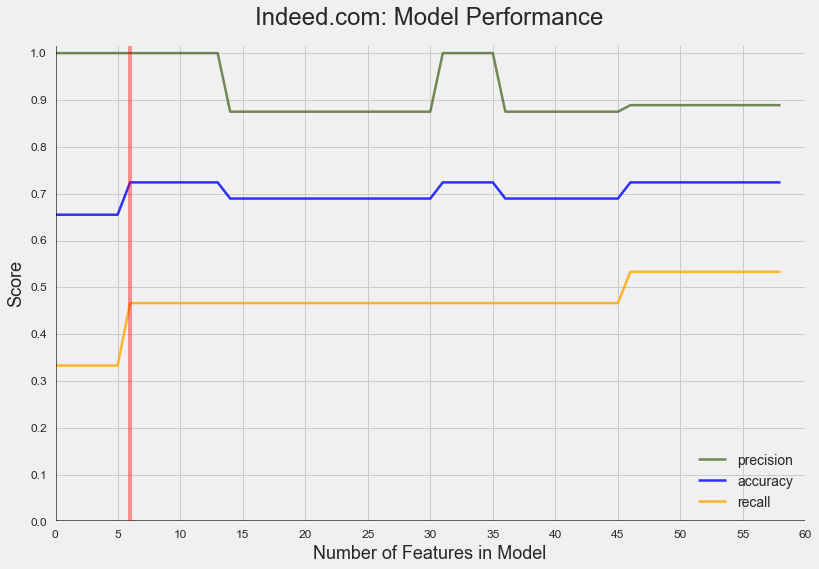

In [198]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in [('precision', 'DarkOliveGreen'), ('accuracy', 'blue'), ('recall', 'Orange')]:
    plt.plot(results.index, results[i[0]], color = i[1], linewidth = 2.5, \
         label = i[0], alpha = 0.8)

plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(0, color='black', alpha = 0.6)
plt.title('Indeed.com: Model Performance', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Score', fontsize = 18)
plt.yticks(np.arange(0, 1.2, 0.1), fontsize = 12)

# x label
plt.xlabel('Number of Features in Model', y = 0.1, fontsize = 18)
plt.xticks(range(0, 70, 5), fontsize = 12)

plt.xlim([-0.1, len(X.columns)])
plt.ylim([0.0, 1.02])
plt.legend(loc='best', fontsize = 14)

plt.axvline(6, color = 'red', alpha = 0.4)

plt.show()

In [199]:
pick_em = SelectKBest(f_classif, k=6)
pick_em.fit(X_train, y_train)
support = X.columns[pick_em.get_support()]
support

Index([u'_develop_', u'is_CA', u'Mountain View', u'Palo Alto', u'Phoenix',
       u'San Jose'],
      dtype='object')

In [200]:
lr2.fit(X_train[support], y_train)
predictions = lr2.predict(X_test[support])
cm = confusion_matrix(predictions, y_test)
cm

array([[14, 10],
       [ 0,  5]])

In [201]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], \
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels, fontsize = 14)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 14)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=40).set_path_effects([path_effects.Stroke(linewidth=1, \
                            foreground='black'), path_effects.Normal()])
    return

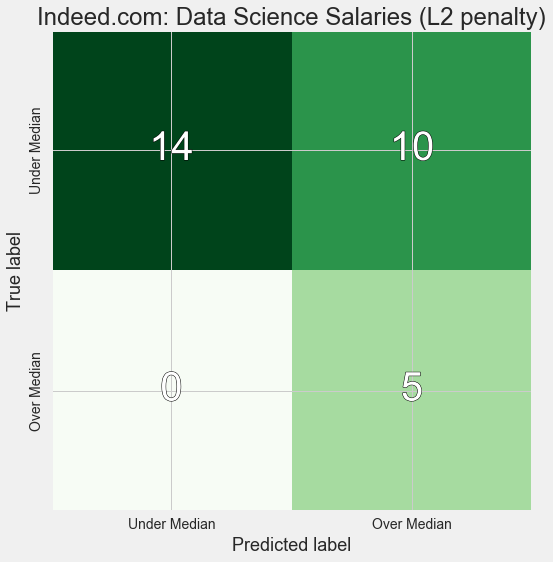

In [202]:
plot_confusion_matrix(cm, title='Indeed.com: Data Science Salaries (L2 penalty)', \
                      labels=['Under Median', 'Over Median'], cmap=plt.cm.Greens)

In [203]:
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, median):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (above median salary)
    plt.figure(figsize=(12,8))
    plt.style.use('fivethirtyeight')
    plt.plot(rate1, rate2, label = 'ROC (area = %0.2f)' % AUC, linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2.5, alpha = 0.5, color = 'magenta')
    plt.xlim([-0.025, 1.01])
    plt.xticks(fontsize = 13)
    plt.ylim([-0.025, 1.05])
    plt.yticks(fontsize = 13)
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title('ROC for Data Science Salaries > %s' %median, fontsize=18)
    plt.legend(loc="best", fontsize = 12)
    plt.axvline(0, linewidth = 1, alpha = 0.5, color = 'black')
    plt.axhline(0, linewidth = 1, alpha = 0.5, color = 'black')
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score, median):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', median)

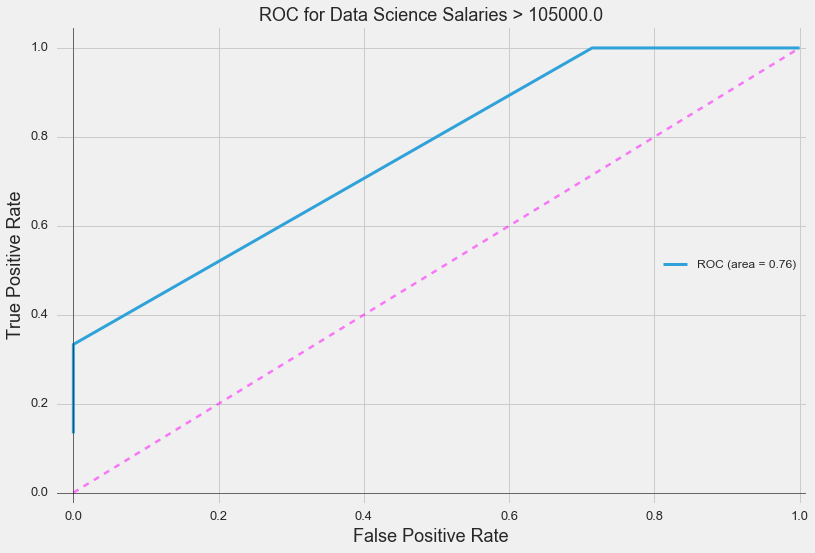

In [204]:
y_score = lr2.decision_function(X_test[support])
plot_roc(y_test, y_score, df['salary'].median())